# ЗАДАЧА

Есть приложение, частью которого является лента публикаций, которые делают пользователи. Для ленты был предложен новый алгоритм рекомендаций. Предполагается, что новый алгоритм должен увеличить конверсию просмотров в лайки - то есть новый алгоритм лучше подбирает посты, которые совпадают с интересами пользователя.

Тест проводился с 2022-04-24 по 2022-04-30. Первая группа выступала контрольной, вторая - тестовой.

Нужно проанализировать, как новый алгоритм повлиял на конверсию и проверить результаты статистическими тестами.

# Импорт библиотек

In [38]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportion_confint

from collections import namedtuple
ExperimentComparisonResults = namedtuple('ExperimentComparisonResults', 
                                        ['pvalue', 'effect', 'ci_length', 'left_bound', 'right_bound', 'plot'])
from tqdm.notebook import tqdm as tqdm_notebook

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns

1.7.1


In [2]:
import warnings
warnings.filterwarnings("ignore")

Создадим подключение к базе данных и напишем функцию для удобства оформления запросов.

In [3]:
connection = {
    'host': '___',
    'password': '___',
    'user': '___',
    'database': '___'
}

In [4]:
def select(sql):
    
    table = pandahouse.read_clickhouse(sql, connection=connection)
    return table

# Анализ данных

Получим из базы данных информацию за период эксперимента для контрольной (1) и тестовой (2) групп.

In [5]:
sql = '''

SELECT  user_id,
        toDate(time) as date,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
        
FROM {db}.feed_actions 
WHERE exp_group = 1 AND 
                        (toDate(time) BETWEEN '2022-04-24' AND '2022-04-30')
GROUP BY user_id, date
ORDER BY date

'''

exp_1 = select(sql)
exp_1.head()

,user_id,date,likes,views,conv
0,20363,2022-04-24,19,61,0.311475
1,19495,2022-04-24,9,39,0.230769
2,27692,2022-04-24,6,28,0.214286
3,1061,2022-04-24,10,26,0.384615
4,126738,2022-04-24,15,55,0.272727


In [6]:
sql = '''
SELECT  user_id,
        toDate(time) as date,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
FROM {db}.feed_actions 
WHERE exp_group = 2 AND 
                        (toDate(time) BETWEEN '2022-04-24' AND '2022-04-30')
GROUP BY user_id, date
ORDER BY date
'''

exp_2 = select(sql)
exp_2.head()

,user_id,date,likes,views,conv
0,114993,2022-04-24,10,22,0.454545
1,107992,2022-04-24,6,50,0.120000
2,19953,2022-04-24,13,44,0.295455
3,117767,2022-04-24,7,45,0.155556
4,25000,2022-04-24,8,19,0.421053


Проверим на пропуски и дубликаты:

In [7]:
print(f'Дубликаты в первой группе: {exp_1.duplicated().sum()}')
print(f'Дубликаты вo второй группе: {exp_2.duplicated().sum()}')
print(f'Пропуски в первой группе: {exp_1.isna().mean()}')
print(f'Пропуски вo второй группе: {exp_2.isna().mean()}')

Дубликаты в первой группе: 0
Дубликаты вo второй группе: 0
Пропуски в первой группе: user_id    0.0
date       0.0
likes      0.0
views      0.0
conv       0.0
dtype: float64
Пропуски вo второй группе: user_id    0.0
date       0.0
likes      0.0
views      0.0
conv       0.0
dtype: float64


**Данные выгружены корректно.**

Посмотрим на размеры групп:

In [8]:
len(exp_1), len(exp_2)

(19468, 19154)

Сколько пользователей попало в каждую из групп:

In [9]:
exp_1['user_id'].nunique(), exp_2['user_id'].nunique()

(10079, 9952)

Важно проверить группы на пересечения, чтобы проверить, корректно ли сработала система сплитования:

In [10]:
set(exp_1['user_id'].unique()).intersection(set(exp_2['user_id'].unique()))

set()

**Пересечений между группами нет, пользователи распределены корректно.**

Изучим, как накапливались события в группах, не было ли аномалий:

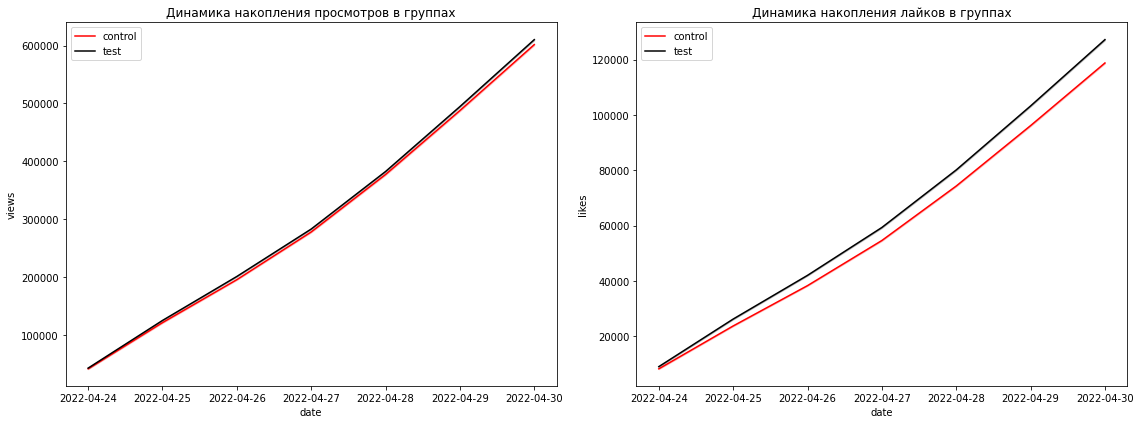

In [11]:
fig, axes = plt.subplots(figsize=(16,6))
plt.subplot(121)
ax1 = sns.lineplot(x=exp_2['date'], y=exp_2['views'].cumsum(), color='red', label='control')
ax1 = sns.lineplot(x=exp_1['date'], y=exp_1['views'].cumsum(), color='k', label='test')
plt.title('Динамика накопления просмотров в группах')
plt.subplot(122)
ax2 = sns.lineplot(x=exp_2['date'], y=exp_2['likes'].cumsum(), color='red', label='control')
ax2 = sns.lineplot(x=exp_1['date'], y=exp_1['likes'].cumsum(), color='k', label='test')
plt.title('Динамика накопления лайков в группах')
plt.tight_layout()
plt.show() 

Тестовая группа сразу же отстала от контрольной по количеству лайков, но в целом события накапливались равномерно.

Посмотрим на распределения лайков и просмотров в тестовой и контрольной группах

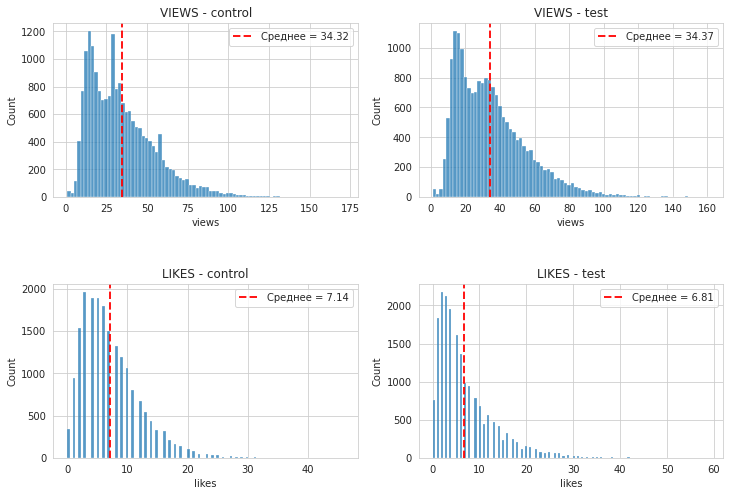

In [12]:
plt.figure(figsize = (12, 8))
plt.subplots_adjust(hspace=0.5)
plt.title('Распределение просмотров и лайков в эксперименте')
sns.set_style('whitegrid')

plt.subplot(221)
ax1 = sns.histplot(exp_1['views'])
ax1.axvline(np.mean(exp_1['views']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_1['views'])))
ax1.set_title('VIEWS - control')
plt.legend()

plt.subplot(222)
ax2 = sns.histplot(exp_2['views'])
ax2.axvline(np.mean(exp_2['views']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_2['views'])))
ax2.set_title('VIEWS - test')
plt.legend()

plt.subplot(223)
ax3 = sns.histplot(exp_1['likes'])
ax3.axvline(np.mean(exp_1['likes']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_1['likes'])))
ax3.set_title('LIKES - control')
plt.legend()

plt.subplot(224)
ax4 = sns.histplot(exp_2['likes'])
ax4.axvline(np.mean(exp_2['likes']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_2['likes'])))
ax4.set_title('LIKES - test')
plt.legend()

plt.show()

**Среднее количество просмотров на пользователя почти не изменилось, а среднее количество лайков в экспериментальной группе снизилось**. Посчитаем конверсии в группах и разницу между ними.

In [13]:
ctr1 = exp_1['likes'].sum() / exp_1['views'].sum()
ctr2 = exp_2['likes'].sum() / exp_2['views'].sum()
print(f'''
Конверсия в контрольной группе: {round(ctr1, 3)}
Конверсия в тестовой группе: {round(ctr2, 3)}

Конверсия снизилась на {round((ctr1-ctr2) / ctr1 * 100, 3)} %
''')


Конверсия в контрольной группе: 0.208
Конверсия в тестовой группе: 0.198

Конверсия снизилась на 4.791 %



Статистическую значимость этого изменения мы проверим в следующем разделе.

Построим график изменения конверсии в группах по дням:

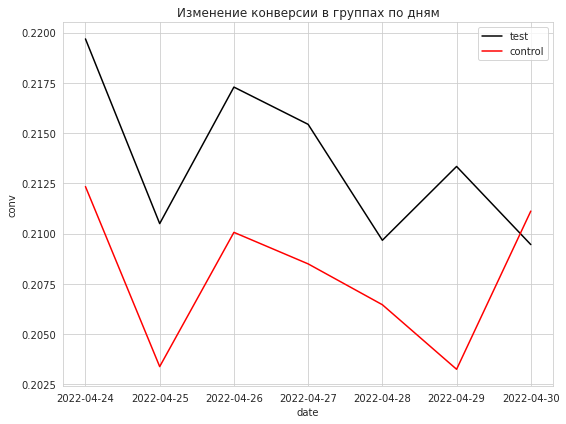

In [14]:
plt.figure(figsize=(8,6))

ax1 = sns.lineplot(data = exp_1.groupby('date', as_index=False)['conv'].mean(), x='date', y='conv', color='k', label='test', ci=None)
ax2 = sns.lineplot(data = exp_2.groupby('date', as_index=False)['conv'].mean(), x='date', y='conv', color='red', label='control', ci=None)
plt.title('Изменение конверсии в группах по дням')
plt.tight_layout()
plt.show() 

Видим, что в последний день эксперимента конверсия в тестовой группе была выше, чем в контрольной.

Посмотрим на динамику лайков и просмотров:

In [15]:
exp_1_gr = exp_1.groupby('date', as_index=False).agg(
    {
    'likes' : 'sum',
    'views' : 'sum'
    })
exp_1_gr['ctr'] = exp_1_gr['likes'] / exp_1_gr['views']
exp_1_gr

,date,likes,views,ctr
0,2022-04-24,18195,85606,0.212544
1,2022-04-25,15927,78079,0.203986
2,2022-04-26,15646,74009,0.211407
3,2022-04-27,19057,90118,0.211467
4,2022-04-28,22425,108708,0.206287
5,2022-04-29,24024,115758,0.207536
6,2022-04-30,23737,115958,0.204703


In [16]:
exp_2_gr = exp_2.groupby('date', as_index=False).agg(
    {
    'likes' : 'sum',
    'views' : 'sum'
    })
exp_2_gr['ctr'] = exp_2_gr['likes'] / exp_2_gr['views']
exp_2_gr

,date,likes,views,ctr
0,2022-04-24,16399,83033,0.197500
1,2022-04-25,14591,76019,0.191939
2,2022-04-26,14595,72760,0.200591
3,2022-04-27,18087,91417,0.197852
4,2022-04-28,21365,107951,0.197914
5,2022-04-29,22151,114369,0.193680
6,2022-04-30,23197,112761,0.205718


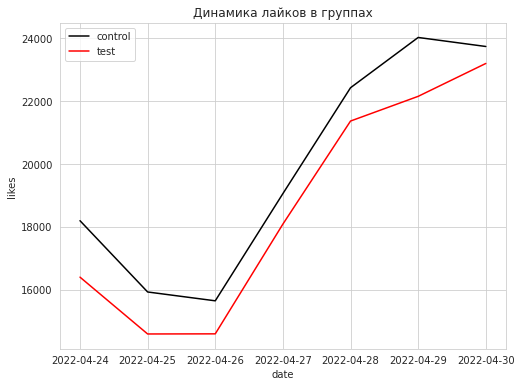

In [17]:
plt.figure(figsize=(8,6))
sns.lineplot(data=exp_1_gr, x='date', y='likes', label='control', color='k')
sns.lineplot(data=exp_2_gr, x='date', y='likes', label='test', color='red')
plt.title('Динамика лайков в группах')
plt.legend()
plt.show()

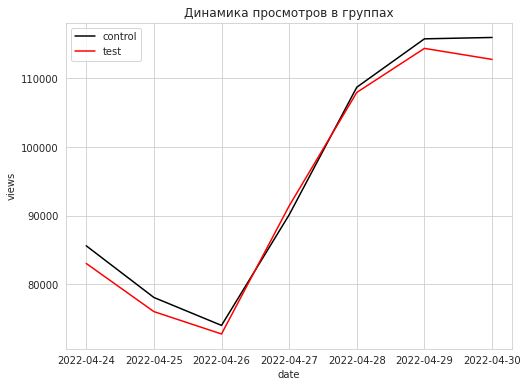

In [18]:
plt.figure(figsize=(8,6))
sns.lineplot(data=exp_1_gr, x='date', y='views', label='control', color='k')
sns.lineplot(data=exp_2_gr, x='date', y='views', label='test', color='red')
plt.title('Динамика просмотров в группах')
plt.legend()
plt.show()

В контрольной группе в последний день снизилось количество лайков, а в тестовой группе оно продолжало расти. С количеством просмотров же была обратная ситуация. Это и привело к тому, что конверсия «теста» в последний день эксперимента обогнала конверсию «контроля».

Возможно, люди начали привыкать к новому алгоритму, и большая продолжительность эксперимента могла бы дать другие результаты.

А теперь визуализируем распределение конверсий в контрольной и тестовой группах:

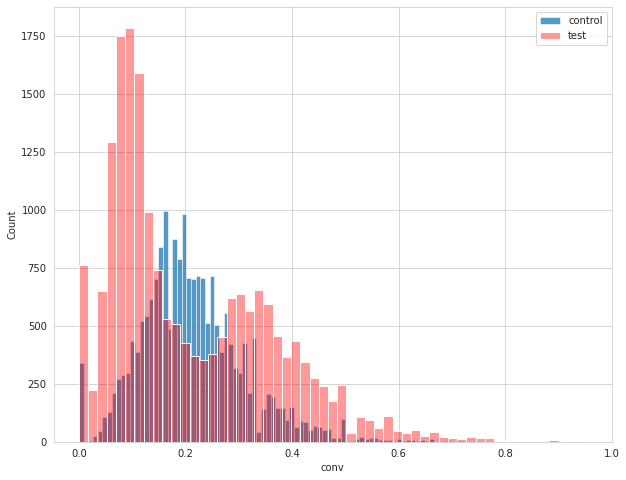

In [19]:
plt.figure(figsize=(10,8))
sns.histplot(exp_1['conv'], label='control')
sns.histplot(exp_2['conv'], color='red', alpha=0.4, label='test')
plt.legend()
plt.show()

**Между гистограммами конверсий есть заметная разница**. Нужно проанализировать новый алгоритм и посмотреть, как он повлиял на пользователей с низкой конверсией и на пользователей с высокой конверсией. Возможно, результаты такого анализа могли бы дать дополнительную полезную информацию.

Проведем анализ. Разобьем всех юзеров на группы по конверсии: отсечем границы групп 25-м и 75-м перцентилями.

In [20]:
exp_1['perc'] = exp_1['conv'].apply(lambda x: 'low' if x <= np.percentile(exp_1['conv'], 25) else ('high' if x >= np.percentile(exp_1['conv'], 75) else 'mid'))

In [21]:
exp_2['perc'] = exp_2['conv'].apply(lambda x: 'low' if x <= np.percentile(exp_2['conv'], 25) else ('high' if x >= np.percentile(exp_2['conv'], 75) else 'mid'))
exp_2.head()

,user_id,date,likes,views,conv,perc
0,114993,2022-04-24,10,22,0.454545,high
1,107992,2022-04-24,6,50,0.120000,mid
2,19953,2022-04-24,13,44,0.295455,mid
3,117767,2022-04-24,7,45,0.155556,mid
4,25000,2022-04-24,8,19,0.421053,high


In [22]:
exp_1_low = (exp_1
                .query('perc == "low" & ("2022-04-24" <= date <= "2022-04-30")')
                .groupby('user_id', as_index=False)['conv'].mean())
exp_2_low = (exp_2
                .query('perc == "low" & ("2022-04-24" <= date <= "2022-04-30")')
                .groupby('user_id', as_index=False)['conv'].mean())

pval_low = ttest_ind(exp_1_low['conv'], exp_2_low['conv'])[1]

exp_1_hi = (exp_1
                .query('perc == "high" & ("2022-04-24" <= date <= "2022-04-30")')
                .groupby('user_id', as_index=False)['conv'].mean())
exp_2_hi = (exp_2
                .query('perc == "high" & ("2022-04-24" <= date <= "2022-04-30")')
                .groupby('user_id', as_index=False)['conv'].mean())

pval_mid = ttest_ind(exp_1_hi['conv'], exp_2_hi['conv'])[1]

exp_1_mid = (exp_1.query('perc == "mid" & ("2022-04-24" <= date <= "2022-04-30")')
                 .groupby('user_id', as_index=False)['conv'].mean())
exp_2_mid = (exp_2.query('perc == "mid" & ("2022-04-24" <= date <= "2022-04-30")')
                 .groupby('user_id', as_index=False)['conv'].mean())
             
pval_hi = ttest_ind(exp_1_mid['conv'], exp_2_mid['conv'])[1]

In [23]:
print(f'''
Конверсия пользователей с низкой конверсией в контрольной группе: {round(exp_1_low['conv'].mean(), 4)}
Конверсия пользователей с низкой конверсией в тестовой группе: {round(exp_2_low['conv'].mean(), 4)}
p-value = {pval_low}''')

print(f'''
Конверсия пользователей со средней конверсией в контрольной группе: {round(exp_1_mid['conv'].mean(), 4)}
Конверсия пользователей со средней конверсией в тестовой группе: {round(exp_2_mid['conv'].mean(), 4)}
p-value = {pval_mid}''')

print(f'''
Конверсия пользователей с высокой конверсией в контрольной группе: {round(exp_1_hi['conv'].mean(), 4)}
Конверсия пользователей с высокой конверсией в тестовой группе: {round(exp_2_hi['conv'].mean(), 4)}
p-value = {pval_hi}''')


Конверсия пользователей с низкой конверсией в контрольной группе: 0.1019
Конверсия пользователей с низкой конверсией в тестовой группе: 0.0548
p-value = 0.0

Конверсия пользователей со средней конверсией в контрольной группе: 0.2039
Конверсия пользователей со средней конверсией в тестовой группе: 0.1783
p-value = 0.0

Конверсия пользователей с высокой конверсией в контрольной группе: 0.3417
Конверсия пользователей с высокой конверсией в тестовой группе: 0.4216
p-value = 1.2046670301469362e-160


**ВЫВОД**

Видим, что конверсии статистически значимо снизились в нижней и средней группах. Зато серьезный прирост в конверсии показали пользователи, чья конверсия была и так высока. Возможно, это связано с тем, что ML алгоритм имеет больше возможности советовать релевантные публикации тем пользователям, которые ставят много лайков на понравившиеся посты.

# Статистические тесты

Проведем исследование и выясним, есть ли статистически значимые отличия между конверсиями в тестовой и контрольной группах. Для этого применим ряд тестов.

## T-test и тест Манна-Уитни

Посмотрим, как ведут себя критерий Манна-Уитни и Т-критерий Стьюдента в контрольной группе

In [24]:
from tqdm import tqdm_notebook

In [25]:
pvalue_t = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=0.5, replace=True)
  norm_2 = exp_1['conv'].sample(frac=0.5, replace=True)
  result = ttest_ind(norm_1, norm_2)
  pvalue_t.append(result.pvalue)
  if result.pvalue < 0.05:
    nums.append(_)
print(f'{len(nums) / len(pvalue_t) * 100}%')
    

  0%|          | 0/10000 [00:00<?, ?it/s]

5.0%


In [26]:
pvalue_u = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=0.5, replace=True)
  norm_2 = exp_1['conv'].sample(frac=0.5, replace=True)
  result = mannwhitneyu(norm_1, norm_2)
  pvalue_u.append(result.pvalue)
  if result.pvalue < 0.05:
    nums.append(_)
print(f'{len(nums) / len(pvalue_u) * 100}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

5.08%


Посмотрим на распределение p-value

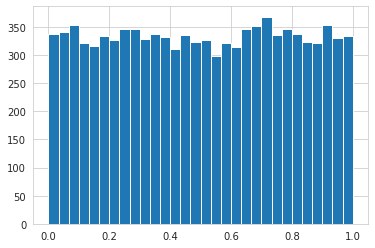

In [27]:
plt.hist(pvalue_t, bins=30)
plt.show()

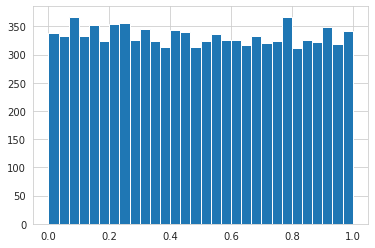

In [28]:
plt.hist(pvalue_u, bins=30)
plt.show()

Оценим мощность тестов. Установим минимальный обнаруживаемый эффект (MDE) в 2%.

In [29]:
conv_mde = exp_1['conv'] * 1.02

pvalue_t_mde = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=0.5, replace=True)
  norm_2 = conv_mde.sample(frac=0.5, replace=True)
  result = ttest_ind(norm_1, norm_2)
  pvalue_t_mde.append(result.pvalue)
  if result.pvalue > 0.05:
    nums.append(_)
print(f'Мощность t-теста: {round(100 - len(nums) / len(pvalue_t_mde) * 100, 3)}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста: 84.63%


In [30]:
pvalue_u_mde = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=0.5, replace=True)
  norm_2 = conv_mde.sample(frac=0.5, replace=True)
  result = mannwhitneyu(norm_1, norm_2)
  pvalue_u_mde.append(result.pvalue)
  if result.pvalue < 0.05:
    nums.append(_)
print(f'Мощность теста Манна-Уитни: {round(len(nums) / len(pvalue_u_mde) * 100, 3)}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность теста Манна-Уитни: 84.28%


**В целом по результатам АА-теста оба критерия показывают пригодность к использованию при уровне значимости 0.05**


Сформулируем гипотезы:
- Нулевая гипотеза: конверсии в контрольной и тестовой группах равны.
- Альтернативная гипотеза: конверсии в контрольной и тестовой группах отличаются.

Сравним конверсии в контрольной и тестовой группах t-тестом:

In [31]:
alpha = 0.05
result = ttest_ind(exp_1['conv'], exp_2['conv'], equal_var=False)
p_value = result.pvalue
print(f"pvalue = {p_value}, \n")
if p_value < alpha:
      print('Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница')
else:
      print(
          'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными'
      ) 

pvalue = 1.5976886967274754e-05, 

Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница


Сравним конверсии в контрольной и тестовой группах тестом Манна-Уитни:

In [32]:
alpha = 0.05
p_value = mannwhitneyu(exp_1['conv'], exp_2['conv']).pvalue
print(f"pvalue = {p_value}, \n")
if p_value < alpha:
      print('Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница')
else:
      print(
          'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными'
      ) 

pvalue = 1.3469462778149872e-107, 

Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница


Посмотрим, как менялся p-value обоих критериев по дням эксперимента:

In [33]:
dates = exp_1['date'].unique()

p_t = [ttest_ind(exp_1.query(f'date <= @dates[{n}]')['conv'], exp_2.query(f'date <= @dates[{n}]')['conv'])[1] for n in range(7)]
p_m = [mannwhitneyu(exp_1.query(f'date <= @dates[{n}]')['conv'], exp_2.query(f'date <= @dates[{n}]')['conv'])[1] for n in range(7)]

p_value_dynamic = pd.DataFrame({
                                't-test' : p_t,
                                'mann_whitney' : p_m
                                },
                                index = range(1,8)
                                )
p_value_dynamic

,t-test,mann_whitney
1,0.050332,4.272023e-21
2,0.006801,6.031364e-42
3,0.000930,3.392526e-56
4,0.000132,5.005028e-78
5,0.000122,1.109714e-94
6,0.000002,2.057860e-123
7,0.000015,1.346946e-107


**Оба критерия показали статистически значимую разницу между конверсиями в группах.**

## Bootstrap

### 1 вариант

Моя собственная реализация бутстрапа.

Проверим статистическую значимость изменения конверсии при помощи бутстрапа.

In [34]:
ctr1 = []
ctr2 = []
ctr_diff = []

for _ in range(10000):
    w1 = exp_1.sample(frac=0.5, replace=True)['views'].sum()
    l1 = exp_1.sample(frac=0.5, replace=True)['likes'].sum()
    w2 = exp_2.sample(frac=0.5, replace=True)['views'].sum()
    l2 = exp_2.sample(frac=0.5, replace=True)['likes'].sum()
    
    ctr_1 = l1/w1
    ctr_2 = l2/w2
    ctr1.append(ctr_1)
    ctr2.append(ctr_2)
    ctr_diff.append(ctr_1-ctr_2)
    
ctr_diff = pd.DataFrame(ctr_diff)

pvalue = 2 * min(np.mean(ctr_diff[0] > 0), np.mean(ctr_diff[0] < 0))

print(f'p-value = {pvalue}')
if pvalue <= 0.05:
    print('Отвергаем нулевую гипотезу: между группами есть статистически значимая разница')
else: 
    print('Не можем отвергнуть нулевую гипотезу: между группами нет статистически значимой разницы')

print(f'''
Среднее значение конверсии контрольной группы: {round(np.mean(ctr1), 3)}
Среднее значение конверсии тестовой группы: {round(np.mean(ctr2), 3)}''')
  
print(f'''
Характеристики распределения конверсии контрольной группы
{pd.Series(ctr1).describe()}

Характеристики распределения конверсии тестовой группы
{pd.Series(ctr2).describe()}
''') 

p-value = 0.0008
Отвергаем нулевую гипотезу: между группами есть статистически значимая разница

Среднее значение конверсии контрольной группы: 0.208
Среднее значение конверсии тестовой группы: 0.198

Характеристики распределения конверсии контрольной группы
count    10000.000000
mean         0.208043
std          0.001874
min          0.201381
25%          0.206753
50%          0.208023
75%          0.209319
max          0.215264
dtype: float64

Характеристики распределения конверсии тестовой группы
count    10000.000000
mean         0.198089
std          0.002174
min          0.189228
25%          0.196646
50%          0.198034
75%          0.199530
max          0.207010
dtype: float64



Визуализируем результаты:

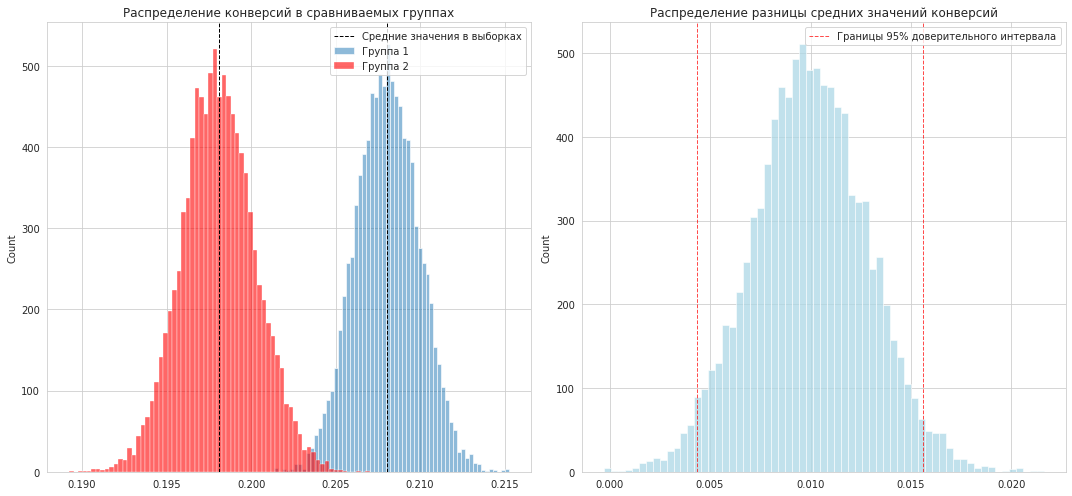

In [35]:
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)
ax1 = sns.histplot(ctr1, 
                     kde=False, 
                     label=f'Группа 1',
                     alpha=0.5)
ax1.axvline(np.mean(ctr1), 
              linewidth=1, 
              color='k', 
              alpha=1, 
              linestyle='--', 
              label='Средние значения в выборках'
              )

ax1 = sns.histplot(ctr2, 
                     color = 'red', 
                     label=f'Группа 2',
                     alpha=0.6)
ax1.axvline(np.mean(ctr2), 
              linewidth=1, 
              color='k', 
              alpha=1, 
              linestyle='--', 
              )
ax1.set_title('Распределение конверсий в сравниваемых группах')
plt.legend()

plt.subplot(1,2,2)
  
sns.set_style('whitegrid')
ax2 = sns.histplot((pd.Series(ctr1) - pd.Series(ctr2)), 
                     color = 'lightblue')
ax2.axvline(ctr_diff[0].quantile(0.025), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--',
                label='Границы 95% доверительного интервала' 
                )
ax2.axvline(ctr_diff[0].quantile(0.975), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--', 
                )
ax2.set_title('Распределение разницы средних значений конверсий')
plt.legend()
plt.tight_layout()
plt.show()

**Бутстрап показывает наличие статистически значимой разницы между конверсиями.**

### 2 вариант

Аналитики из Авито написали крутую статью, которую я прочел в блоге на Хабре (https://habr.com/ru/company/avito/blog/571096/). В образовательных целях взял оттуда эту функцию с небольшими упрощениями:

In [44]:
def bootstrap(control, test):
    
    stat_sample = []
    
    batch_sz = 100
    
    # В теории boot_samples_size стоить брать не меньше размера выборки. Но на практике можно и меньше.
    boot_samples_size = len(control)
    for i in range(0, boot_samples_size, batch_sz):
        N_c = len(control)
        N_t = len(test)
        control_sample = np.random.choice(control, size=(len(control), batch_sz), replace=True)
        test_sample    = np.random.choice(test, size=(len(test), batch_sz), replace=True)

        C = np.mean(control_sample, axis=0)
        T = np.mean(test_sample, axis=0)
        assert len(T) == batch_sz
        
        # Добавляем в массив посчитанных ранее статистик batch_sz новых значений
        # X в статье – это boot_func(control_sample_mean, test_sample_mean)
        stat_sample += list(C - T)

    stat_sample = np.array(stat_sample)
    # Считаем истинный эффект
    effect = np.mean(control) - np.mean(test)
    left_bound, right_bound = np.quantile(stat_sample, [0.025, 0.975])
    
    ci_length = (right_bound - left_bound)
    # P-value - процент статистик, которые лежат левее или правее 0.
    pvalue = 2 * min(np.mean(stat_sample > 0), np.mean(stat_sample < 0))
    
    print(f'p-value = {pvalue}')
    plt.figure(figsize=(8,6))
    plot = sns.histplot(stat_sample)
    plot.axvline(np.quantile(stat_sample.tolist(), 0.025),
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--',
                label='Границы 95% доверительного интервала' 
                )
    plot.axvline(np.quantile(stat_sample.tolist(), 0.975), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--', 
                )
    plt.show()
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound, plot)

p-value = 0.0


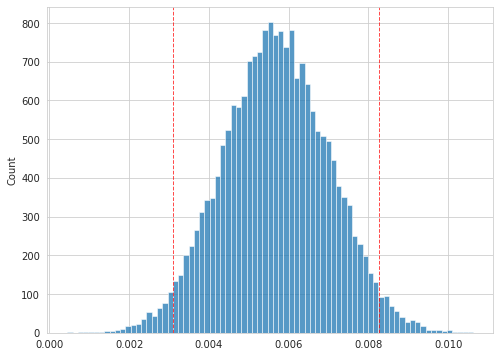

In [46]:
p_value_bootstrap_2 = bootstrap(exp_1['conv'], exp_2['conv'])

**Видим, что этот тест тоже показывает статистически значимую разницу между группами. Ноль не попадает в доверительный интервал.**

## CUPED 

Попробуем еще один способ : CUPED, это метод постанализа, понижающий дисперсию. Реализация метода взята из вышеупомянутой статьи в образовательных целях.

Для расчета предэкспериментальной метрики берем период в 1 месяц до итсследуемого эксперимента. Выгружаем данные:

In [ ]:
sql = '''
SELECT  user_id,
        toDate(time) as date,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
        
FROM {db}.feed_actions 
WHERE exp_group = 2 AND 
                        (toDate(time) BETWEEN '2022-03-23' AND '2022-04-23')
GROUP BY user_id, date
ORDER BY date

'''

exp_tb = select(sql)
exp_tb.head()

In [ ]:
sql = '''
SELECT  user_id,
        toDate(time) as date,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
        
FROM {db}.feed_actions 
WHERE exp_group = 1 AND 
                        (toDate(time) BETWEEN '2022-03-23' AND '2022-04-23')
GROUP BY user_id, date
ORDER BY date

'''

exp_cb = select(sql)
exp_cb.head()

Создаем списки конверсий в тесте и контроле до эксперимента и во время эксперимента:

In [ ]:
test_before = exp_tb['conv']
test = exp_2['conv']

control_before = exp_cb['conv']
control = exp_1['conv']


Используем функцию для вычисления параметров теста и считаем p-value.

In [ ]:
def absolute_ttest(control, test):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    
    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = stats.norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))

    left_bound, right_bound = difference_distribution.ppf([0.025, 0.975])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)


In [ ]:
pvalue_cuped = absolute_ttest(control, test)[0]
pvalue_cuped

**CUPED показывает наличие статистически значимых различий между контрольной и тестовой группами.**

# ВЫВОД 

- Система сплитования работает корректно - пересечений между группа не обнаружено.
- В данных нет пропусков и дубликатов.
- После введения нового алгоритма снизилось среднее количество лайков и снизилась общая конверсия: с 0.208 до 0.198.
- Для проверки статистической значимости этого изменения были применены несколько критериев: t-тест, тест Манна-Уитни, бутстрап и CUPED. Все эти методы показали, что изменение конверсии статистически значимо.
- В то же время на пользователях с высокой конверсией алгоритм показал себя хорошо: конверсия увеличилась с 34.4% до 42.5%.

**РЕКОМЕНДАЦИИ**

Изучить, почему алгоритм оказывает противоположное влияние на пользователей с высокой конверсией и на пользователей с низкой конверсией, выполнить необходимые подстройки.  Выпускать новый алгоритм в продакшн на всех пользователей не рекомендуется.